https://www.kaggle.com/code/ahmedashrafhelmi/ecg-classification-rnn-gru-lstm

In [1]:
import torch
print("PyTorch version:", torch.__version__)

# Check if CUDA is available
print("CUDA available:", torch.cuda.is_available())

# Get current CUDA device index (if available)
if torch.cuda.is_available():
    print("Current CUDA device index:", torch.cuda.current_device())
    print("CUDA device name:", torch.cuda.get_device_name(torch.cuda.current_device()))
else:
    print("No CUDA devices found.")

PyTorch version: 2.5.1+cu124
CUDA available: True
Current CUDA device index: 0
CUDA device name: NVIDIA GeForce GTX 1660 SUPER


In [2]:
import pandas as pd
import numpy as np
from torch import nn, optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import os
dataframes = {}
# directory_path = 'Arrhythmia_Dataset'
directory_path = 'Heartbeat_Dataset'
all_files = os.listdir(directory_path)

for file in os.listdir(directory_path):
    if file.endswith('.csv'):
        file_path = os.path.join(directory_path, file)
        # Remove the .csv extension for the DataFrame name
        df_name = os.path.splitext(file)[0]
        dataframes[df_name] = pd.read_csv(file_path)


In [3]:
print(dataframes.keys())

dict_keys(['mitbih_test', 'mitbih_train', 'ptbdb_abnormal', 'ptbdb_normal'])


## Exploratory Data Analysis

In [4]:
# df = dataframes['MIT-BIH Arrhythmia Database']

# Retrieve train and test datasets
train_df = dataframes['mitbih_train']
test_df = dataframes['mitbih_test']

In [5]:
# Preview of train dataset
train_df.head()

,9.779411554336547852e-01,9.264705777168273926e-01,6.813725233078002930e-01,2.450980395078659058e-01,1.544117629528045654e-01,1.911764740943908691e-01,1.519607901573181152e-01,8.578431606292724609e-02,5.882352963089942932e-02,4.901960864663124084e-02,...,0.000000000000000000e+00.79,0.000000000000000000e+00.80,0.000000000000000000e+00.81,0.000000000000000000e+00.82,0.000000000000000000e+00.83,0.000000000000000000e+00.84,0.000000000000000000e+00.85,0.000000000000000000e+00.86,0.000000000000000000e+00.87,0.000000000000000000e+00.88
0,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.927461,1.000000,0.626943,0.193437,0.094991,0.072539,0.043178,0.053541,0.093264,0.189983,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
# Check number of samples in datasets
print(f"Number of samples in train data: {train_df.shape[0]}, test data: {test_df.shape[0]}\n")

# Check distribution of classes in test and train sets
print("Train dataset class distribution")
print(train_df.iloc[:, -1].value_counts())
print("\nTest dataset class distribution")
print(test_df.iloc[:, -1].value_counts())

Number of samples in train data: 87553, test data: 21891

Train dataset class distribution
0.000000000000000000e+00.88
0.0    72470
4.0     6431
2.0     5788
1.0     2223
3.0      641
Name: count, dtype: int64

Test dataset class distribution
0.000000000000000000e+00.65
0.0    18117
4.0     1608
2.0     1448
1.0      556
3.0      162
Name: count, dtype: int64


In [7]:
# Labels for numbered categories
labels = {
    0: "N",
    1: "S",
    2: "V",
    3: "F",
    4: "Q"
}

In [8]:
# Missing/Duplicate values

C:\Users\User\AppData\Local\Temp\ipykernel_27712\3740686426.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.annotate(f'{train_counts[i]}',


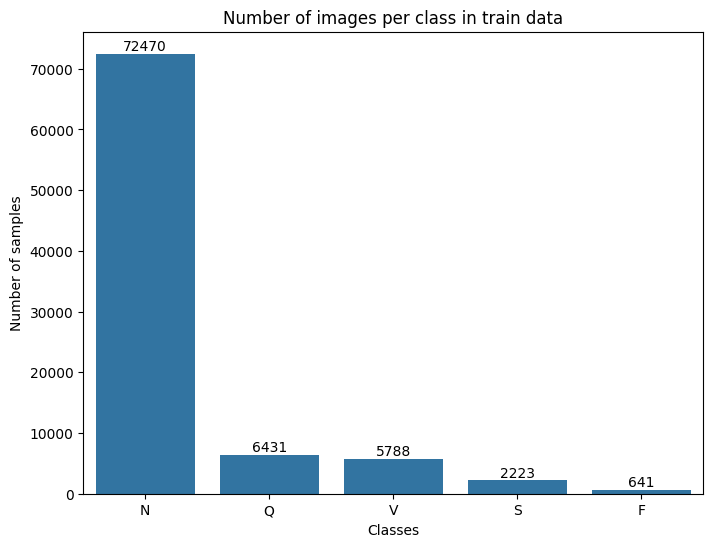

In [9]:
import seaborn as sb
import matplotlib.pyplot as plt

train_counts = train_df.iloc[:,-1].value_counts().rename(labels)

plt.figure(figsize=(8, 6))
ax = sb.barplot(x=train_counts.index, y=train_counts.values)

# Annotate each bar with the count
for i, p in enumerate(ax.patches):
    ax.annotate(f'{train_counts[i]}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom', 
                fontsize=10)

plt.title('Number of images per class in train data')
plt.xlabel('Classes')
plt.ylabel('Number of samples')
plt.show()

C:\Users\User\AppData\Local\Temp\ipykernel_27712\578734644.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.annotate(f'{test_counts[i]}',


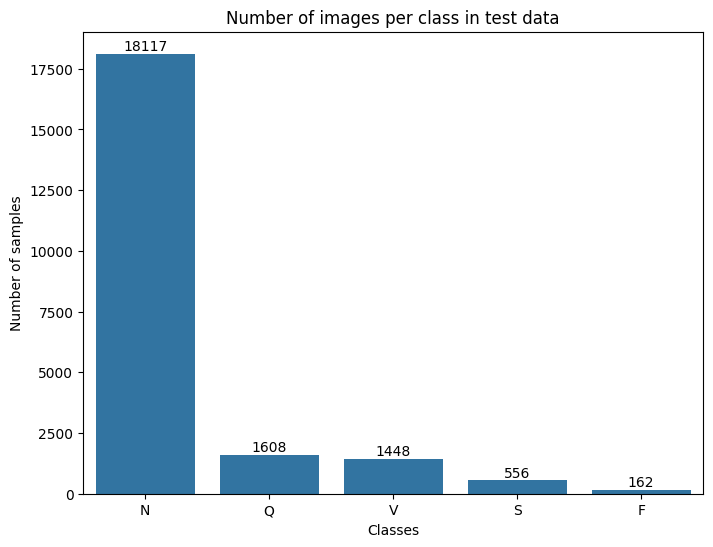

In [10]:
test_counts = test_df.iloc[:,-1].value_counts().rename(labels)

plt.figure(figsize=(8, 6))
ax = sb.barplot(x=test_counts.index, y=test_counts.values)

# Annotate each bar with the count
for i, p in enumerate(ax.patches):
    ax.annotate(f'{test_counts[i]}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom', 
                fontsize=10)

plt.title('Number of images per class in test data')
plt.xlabel('Classes')
plt.ylabel('Number of samples')
plt.show()

In [11]:
SEED = 11
torch.manual_seed(SEED)

## Preprocess dataset

In [12]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Separate features and labels
X_train = train_df.iloc[:, :-1].values  # Exclude label
y_train = train_df.iloc[:, -1].values   # Labels

X_test = test_df.iloc[:, :-1].values
y_test = test_df.iloc[:, -1].values

# Scaling the dataset
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Split the training data to obtain new train and validation sets
# Stratifying the split so both train and validation sets have same class distribution
X_train_new, X_val, y_train_new, y_val = train_test_split(X_train_scaled, y_train, test_size=0.2, random_state=SEED, stratify=y_train)

print(f"New Training set: {X_train_new.shape}")
print(f"Validation set: {X_val.shape}")
print(f"Test set: {X_test_scaled.shape}")

New Training set: (70042, 187)
Validation set: (17511, 187)
Test set: (21891, 187)


In [41]:
# Reshape the data for RNN/LSTM/GRU (samples, timesteps, features), one feature per timestep
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train_new = np.reshape(X_train_new, (X_train_new.shape[0], X_train_new.shape[1], 1))
X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 1))
X_test_scaled = np.reshape(X_test_scaled, (X_test.shape[0], X_test.shape[1], 1))

print(f"New Training set size: {X_train_new.shape}")
print(f"Validation set size: {X_val.shape}")
print(f"Test set size: {X_test_scaled.shape}")

New Training set size: (70042, 187, 1)
Validation set size: (17511, 187, 1)
Test set size: (21891, 187, 1)


## RNN Model

In [14]:
class RNNModel(nn.Module):
    def __init__(self, inputSize, hiddenSize, numLayers, numClasses):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(
            input_size = inputSize,
            hidden_size = hiddenSize,
            num_layers = numLayers,
            batch_first = True
        )

        self.fc = nn.Linear(hiddenSize, numClasses)
        return

    def forward(self, x):
        # Forward pass through RNN layers
        out, _ = self.rnn(x)

        # Use output from last timestep
        out = out[:, -1, :]

        # Pass output to fully connected layer
        out = self.fc(out)

        return out

In [15]:
# Variables
inputSize = 1
hiddenSize = 64
numClasses = 5
numLayers = 1
learningRate = 0.001
numEpochs = 20

In [16]:
# Instantiate model
rnn_model = RNNModel(inputSize, hiddenSize, numLayers, numClasses)
rnn_optimizer = optim.Adam(rnn_model.parameters(), lr=learningRate)

# Loss function
criterion = nn.CrossEntropyLoss()

In [17]:
# Prepare datasets in batches
from torch.utils.data import DataLoader, TensorDataset

# Define batch size
batchSize = 32

# Create DataLoader for training and validation sets
def get_dataloaders(X_train, X_test, y_train, y_test):
    train_dataset = TensorDataset(torch.as_tensor(X_train, dtype=torch.float), torch.as_tensor(y_train, dtype=torch.float))
    val_dataset = TensorDataset(torch.as_tensor(X_test, dtype=torch.float), torch.as_tensor(y_test, dtype=torch.float))

    train_loader = DataLoader(train_dataset, batch_size=batchSize, shuffle=True)
    test_loader = DataLoader(val_dataset, batch_size=batchSize)

    return train_loader, test_loader

In [22]:
def train_val(model, optimizer, train_loader, test_loader):

    # Move model to GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    train_losses, train_accuracies = [], []
    test_losses, test_accuracies = [], []

    for epoch in range(numEpochs):
        model.train()  # Set the model to training mode
        train_loss = 0
        train_correct = 0
        
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)  # Move data to device
            # X_batch = X_batch.unsqueeze(-1) # Dataloader collapses last dimension of 1
            
            # Forward pass
            outputs = model(X_batch)
            # print(f'Output {outputs.shape}, y_batch {y_batch.shape}')
            loss = criterion(outputs, y_batch.long())
            
            # Backward pass and optimization
            optimizer.zero_grad()  # Clear gradients
            loss.backward()        # Backpropagation
            optimizer.step()       # Update weights

            # Get predictions
            _, predicted = torch.max(outputs, 1)
            train_correct += (predicted == y_batch).sum().item()
            
            train_loss += loss.item() * X_batch.size(0)  # Accumulate loss
        
        # Calculate average training loss
        train_loss /= len(train_loader.dataset)
        train_accuracy = train_correct / len(train_loader.dataset)

        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        
        # Validation/Testing
        model.eval()  # Set the model to evaluation mode
        test_loss = 0
        correct = 0
        
        with torch.no_grad():  # No need to calculate gradients for validation
            for X_batch, y_batch in test_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                # print(f"X_batch {X_batch.shape}")
                # X_batch = X_batch.unsqueeze(-1) # Dataloader collapses last dimension of 1
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch.long())
                test_loss += loss.item() * X_batch.size(0)
                
                # Get predictions
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == y_batch).sum().item()
        
        # Calculate average validation loss and accuracy
        test_loss /= len(test_loader.dataset)
        test_accuracy = correct / len(test_loader.dataset)

        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)
        
        # Print epoch results
        print(f'Epoch [{epoch + 1}/{numEpochs}], '
            f'Train Loss: {train_loss:.4f}, '
            f'Train Accuracy: {train_accuracy * 100:.2f}%, '
            f'Test Loss: {test_loss:.4f}, '
            f'Test Accuracy: {test_accuracy * 100:.2f}%')
        
    return train_losses, train_accuracies, test_losses, test_accuracies

In [23]:
train_loader, val_loader = get_dataloaders(X_train_new, X_val, y_train_new, y_val)
train_losses, train_accuracies, val_losses, val_accuracies = train_val(rnn_model, rnn_optimizer, train_loader, val_loader)

Epoch [1/20], Train Loss: 0.6510, Train Accuracy: 82.82%, Test Loss: 0.6534, Test Accuracy: 82.80%
Epoch [2/20], Train Loss: 0.6510, Train Accuracy: 82.79%, Test Loss: 0.6537, Test Accuracy: 82.76%
Epoch [3/20], Train Loss: 0.6494, Train Accuracy: 82.79%, Test Loss: 0.6506, Test Accuracy: 82.69%
Epoch [4/20], Train Loss: 0.6505, Train Accuracy: 82.81%, Test Loss: 0.6539, Test Accuracy: 82.77%
Epoch [5/20], Train Loss: 0.6506, Train Accuracy: 82.79%, Test Loss: 0.6497, Test Accuracy: 82.69%
Epoch [6/20], Train Loss: 0.6513, Train Accuracy: 82.82%, Test Loss: 0.6505, Test Accuracy: 82.80%
Epoch [7/20], Train Loss: 0.6506, Train Accuracy: 82.80%, Test Loss: 0.6508, Test Accuracy: 82.73%
Epoch [8/20], Train Loss: 0.6498, Train Accuracy: 82.81%, Test Loss: 0.6285, Test Accuracy: 82.77%
Epoch [9/20], Train Loss: 0.6255, Train Accuracy: 82.80%, Test Loss: 0.6479, Test Accuracy: 82.77%
Epoch [10/20], Train Loss: 0.6312, Train Accuracy: 82.81%, Test Loss: 0.6274, Test Accuracy: 82.69%
Epoch [11

In [24]:
PATH = "./model/simple_rnn_model.pth"
# Save trained model
torch.save(rnn_model.state_dict(), PATH)

In [ ]:
# Load model
PATH = "./model/simple_rnn_model.pth"
rnn_model = RNNModel(inputSize, hiddenSize, numLayers, numClasses)
rnn_model = rnn_model.load_state_dict(torch.load(PATH, weights_only=True))

C:\Users\User\AppData\Local\Temp\ipykernel_27712\391341765.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  rnn_model = rnn_model.load_state_dict(torch.load(PATH))


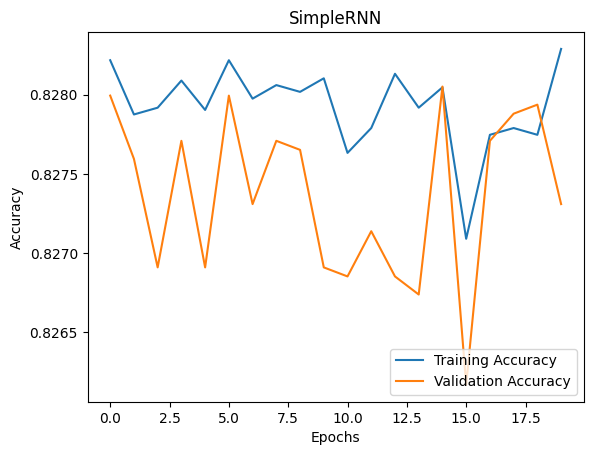

In [26]:
plt.figure()
plt.plot(np.arange(numEpochs), train_accuracies, label='Training Accuracy')
plt.plot(np.arange(numEpochs), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('SimpleRNN')
plt.legend(loc='lower right')
plt.show()

## Long Short Term Memory (LSTM) Model

In [27]:
class LSTMModel(nn.Module):
    def __init__(self, inputSize, hiddenSize, numLayers, numClasses):
        super(LSTMModel, self).__init__()
        
        # Define the LSTM layer
        self.lstm = nn.LSTM(input_size = inputSize, 
                            hidden_size = hiddenSize, 
                            num_layers = numLayers, 
                            batch_first=True
                            )
        
        # Define a fully connected output layer
        self.fc = nn.Linear(hiddenSize, numClasses)
    
    def forward(self, x):
        # Initialize hidden and cell states
        h0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).to(x.device)
        c0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).to(x.device)
        
        # Forward propagate through LSTM
        out, _ = self.lstm(x, (h0, c0))
        
        # Take the output from the last time step
        out = out[:, -1, :]
        
        # Pass through the fully connected layer
        out = self.fc(out)
        return out

In [28]:
# Create DataLoader for training and validation sets
train_dataset = TensorDataset(torch.as_tensor(X_train, dtype=torch.float), torch.as_tensor(y_train, dtype=torch.float))
val_dataset = TensorDataset(torch.as_tensor(X_val, dtype=torch.float), torch.as_tensor(y_val, dtype=torch.float))

train_loader = DataLoader(train_dataset, batch_size=batchSize, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batchSize)

In [29]:
# Instantiate model
lstm_model = LSTMModel(inputSize, hiddenSize, numLayers, numClasses)
lstm_optimizer = optim.Adam(lstm_model.parameters(), lr=learningRate)

In [30]:
train_loader, val_loader = get_dataloaders(X_train_new, X_val, y_train_new, y_val)
train_losses, train_accuracies, val_losses, val_accuracies = train_val(lstm_model, lstm_optimizer, train_loader, val_loader)

Epoch [1/20], Train Loss: 0.6650, Train Accuracy: 82.44%, Test Loss: 0.6508, Test Accuracy: 82.83%
Epoch [2/20], Train Loss: 0.6465, Train Accuracy: 82.76%, Test Loss: 0.6404, Test Accuracy: 82.66%
Epoch [3/20], Train Loss: 0.5751, Train Accuracy: 82.87%, Test Loss: 0.5124, Test Accuracy: 84.29%
Epoch [4/20], Train Loss: 0.4574, Train Accuracy: 86.50%, Test Loss: 0.4114, Test Accuracy: 88.29%
Epoch [5/20], Train Loss: 0.3972, Train Accuracy: 88.70%, Test Loss: 0.3547, Test Accuracy: 90.30%
Epoch [6/20], Train Loss: 0.6561, Train Accuracy: 82.70%, Test Loss: 0.6508, Test Accuracy: 82.78%
Epoch [7/20], Train Loss: 0.6483, Train Accuracy: 82.82%, Test Loss: 0.6491, Test Accuracy: 82.70%
Epoch [8/20], Train Loss: 0.4937, Train Accuracy: 86.61%, Test Loss: 0.3551, Test Accuracy: 90.78%
Epoch [9/20], Train Loss: 0.3395, Train Accuracy: 91.34%, Test Loss: 0.3307, Test Accuracy: 91.61%
Epoch [10/20], Train Loss: 0.3031, Train Accuracy: 92.16%, Test Loss: 0.2855, Test Accuracy: 92.31%
Epoch [11

In [31]:
PATH = "./model/lstm_rnn_model.pth"
# Save trained model
torch.save(lstm_model.state_dict(), PATH)

In [32]:
# Load model
PATH = "./model/lstm_rnn_model.pth"
lstm_model = LSTMModel(inputSize, hiddenSize, numLayers, numClasses)
lstm_model = lstm_model.load_state_dict(torch.load(PATH, weights_only=True))

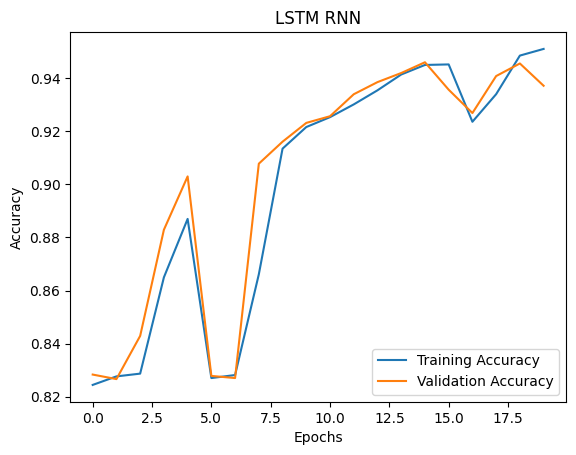

In [33]:
plt.figure()
plt.plot(np.arange(numEpochs), train_accuracies, label='Training Accuracy')
plt.plot(np.arange(numEpochs), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('LSTM RNN')
plt.legend(loc='lower right')
plt.show()

## Gated Recurrent Unit (GRU)

In [34]:
class GRUModel(nn.Module):
    def __init__(self, inputSize, hiddenSize, numLayers, numClasses):
        super(GRUModel, self).__init__()
        
        # Define the GRU layer
        self.gru = nn.GRU(input_size=inputSize, 
                          hidden_size=hiddenSize, 
                          num_layers=numLayers, 
                          batch_first=True
                          )
        
        # Define a fully connected output layer
        self.fc = nn.Linear(hiddenSize, numClasses)
    
    def forward(self, x):
        # Initialize hidden state for GRU
        h0 = torch.zeros(self.gru.num_layers * (2 if self.gru.bidirectional else 1), x.size(0), self.gru.hidden_size).to(x.device)
        
        # Forward propagate through GRU
        out, _ = self.gru(x, h0)
        
        # Take the output from the last time step
        out = out[:, -1, :]
        
        # Pass through the fully connected layer
        out = self.fc(out)
        return out

In [35]:
# Instantiate model
gru_model = GRUModel(inputSize, hiddenSize, numLayers, numClasses)
gru_optimizer = optim.Adam(gru_model.parameters(), lr=learningRate)

In [36]:
train_loader, val_loader = get_dataloaders(X_train_new, X_val, y_train_new, y_val)
train_losses, train_accuracies, val_losses, val_accuracies = train_val(gru_model, gru_optimizer, train_loader, val_loader)

Epoch [1/20], Train Loss: 0.4968, Train Accuracy: 85.92%, Test Loss: 0.3548, Test Accuracy: 90.54%
Epoch [2/20], Train Loss: 0.2906, Train Accuracy: 92.11%, Test Loss: 0.2581, Test Accuracy: 92.90%
Epoch [3/20], Train Loss: 0.2499, Train Accuracy: 93.43%, Test Loss: 0.2269, Test Accuracy: 94.01%
Epoch [4/20], Train Loss: 0.2196, Train Accuracy: 94.27%, Test Loss: 0.2088, Test Accuracy: 94.39%
Epoch [5/20], Train Loss: 0.1864, Train Accuracy: 95.11%, Test Loss: 0.1830, Test Accuracy: 94.91%
Epoch [6/20], Train Loss: 0.1684, Train Accuracy: 95.50%, Test Loss: 0.1679, Test Accuracy: 95.58%
Epoch [7/20], Train Loss: 0.1575, Train Accuracy: 95.76%, Test Loss: 0.1513, Test Accuracy: 95.82%
Epoch [8/20], Train Loss: 0.1457, Train Accuracy: 96.10%, Test Loss: 0.1400, Test Accuracy: 96.17%
Epoch [9/20], Train Loss: 0.1361, Train Accuracy: 96.29%, Test Loss: 0.1381, Test Accuracy: 96.12%
Epoch [10/20], Train Loss: 0.1267, Train Accuracy: 96.63%, Test Loss: 0.1415, Test Accuracy: 96.36%
Epoch [11

In [37]:
PATH = "./model/gru_rnn_model.pth"
# Save trained model
torch.save(gru_model.state_dict(), PATH)

In [38]:
# Load model
PATH = "./model/gru_rnn_model.pth"
gru_model = GRUModel(inputSize, hiddenSize, numLayers, numClasses)
gru_model = gru_model.load_state_dict(torch.load(PATH, weights_only=True))

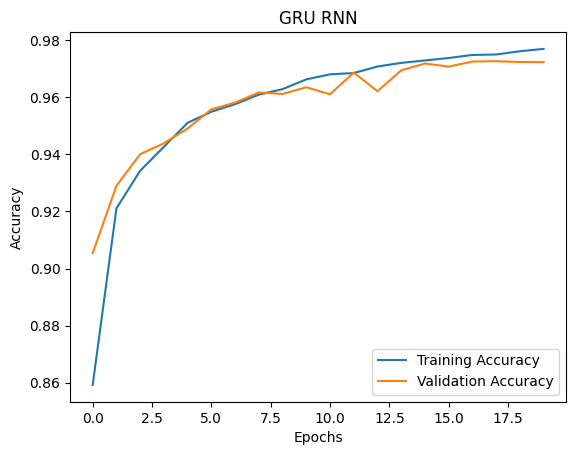

In [39]:
plt.figure()
plt.plot(np.arange(numEpochs), train_accuracies, label='Training Accuracy')
plt.plot(np.arange(numEpochs), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('GRU RNN')
plt.legend(loc='lower right')
plt.show()

## Testing best model on entire dataset

In [42]:
# Instantiate model
gru_model = GRUModel(inputSize, hiddenSize, numLayers, numClasses)
gru_optimizer = optim.Adam(gru_model.parameters(), lr=learningRate)

train_loader, test_loader = get_dataloaders(X_train, X_test_scaled, y_train, y_test)
train_losses, train_accuracies, test_losses, test_accuracies = train_val(gru_model, gru_optimizer, train_loader, test_loader)

Epoch [1/20], Train Loss: 0.4900, Train Accuracy: 86.53%, Test Loss: 0.3719, Test Accuracy: 89.54%
Epoch [2/20], Train Loss: 0.3462, Train Accuracy: 90.36%, Test Loss: 0.3248, Test Accuracy: 92.02%
Epoch [3/20], Train Loss: 0.3401, Train Accuracy: 91.02%, Test Loss: 0.3401, Test Accuracy: 90.93%
Epoch [4/20], Train Loss: 0.3141, Train Accuracy: 91.72%, Test Loss: 0.2908, Test Accuracy: 92.79%
Epoch [5/20], Train Loss: 0.3501, Train Accuracy: 90.73%, Test Loss: 0.3128, Test Accuracy: 92.21%
Epoch [6/20], Train Loss: 0.2669, Train Accuracy: 93.12%, Test Loss: 0.2346, Test Accuracy: 93.92%
Epoch [7/20], Train Loss: 0.2261, Train Accuracy: 93.95%, Test Loss: 0.2219, Test Accuracy: 93.97%
Epoch [8/20], Train Loss: 0.2044, Train Accuracy: 94.36%, Test Loss: 0.1959, Test Accuracy: 94.52%
Epoch [9/20], Train Loss: 0.1868, Train Accuracy: 94.83%, Test Loss: 0.1931, Test Accuracy: 95.11%
Epoch [10/20], Train Loss: 0.1722, Train Accuracy: 95.08%, Test Loss: 0.1731, Test Accuracy: 95.17%
Epoch [11

In [43]:
# Save trained model
PATH = "./model/best_rnn_model.pth"
torch.save(gru_model.state_dict(), PATH)

In [44]:
# Load model
PATH = "./model/best_rnn_model.pth"
gru_model = GRUModel(inputSize, hiddenSize, numLayers, numClasses)
gru_model = gru_model.load_state_dict(torch.load(PATH, weights_only=True))

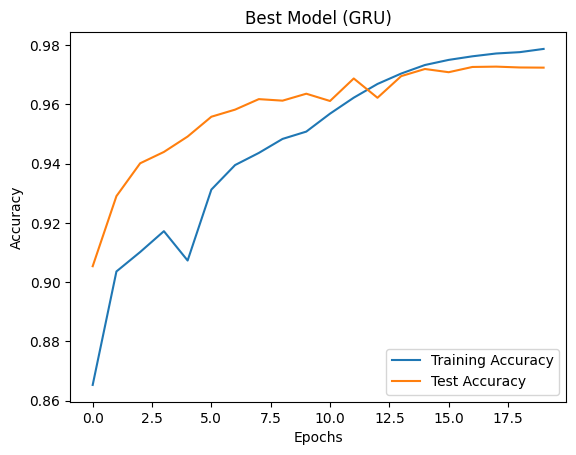

In [45]:
plt.figure()
plt.plot(np.arange(numEpochs), train_accuracies, label='Training Accuracy')
plt.plot(np.arange(numEpochs), val_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Best Model (GRU)')
plt.legend(loc='lower right')
plt.show()